In [10]:
import numpy as np
from tallem.alignment import opa
np.random.seed(7)

In [11]:
from numpy.linalg import qr 
X = np.random.uniform(size=(100,2))

## will almost certainly be a reflection
R, _ = qr(np.random.uniform(size=(2,2)))

# Hand-rolled rotation
# theta = 0.96*np.pi
# R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

Y = ((X @ R)*3.0) + np.array([1.5, -6.7])
print("Random orthogonal: ", R)
print("det R: ", np.linalg.det(R))
print("Translation: ", Y.mean(axis=0) - X.mean(axis=0))


Random orthogonal:  [[-0.71046702 -0.7037305 ]
 [-0.7037305   0.71046702]]
det R:  -0.9999999999999997
Translation:  [-1.06759769 -7.18559237]


X center:  [0.49127015 0.48751324]
Y center:  [-0.57632754 -6.69807913]


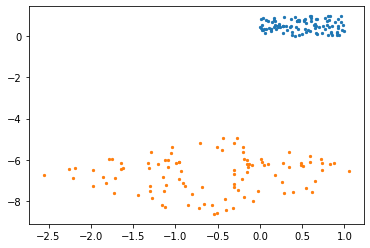

In [6]:
import matplotlib.pyplot as plt
plt.scatter(*X.T, s=5)
plt.scatter(*Y.T, s=5)
print("X center: ", X.mean(axis=0))
print("Y center: ", Y.mean(axis=0))

In [8]:
from tallem.alignment import opa
align = opa(X, Y, coords=False)
print("R: ", align['rotation'])
print("Computed scaling: ", align['scaling'])
print("Computed translation: ", align['translation'])

from scipy.linalg import orthogonal_procrustes
R_scipy, ss = orthogonal_procrustes(X, Y)
print("R scipy: ", R_scipy)

R:  [[-0.71046702 -0.7037305 ]
 [-0.7037305   0.71046702]]
Computed scaling:  3.0
Computed translation:  [-1.06759769 -7.18559237]
R scipy:  [[ 0.55914312 -0.82907115]
 [-0.82907115 -0.55914312]]


In [ ]:
def opa(a: npt.ArrayLike, b: npt.ArrayLike, transform=False, rotation_only=True):
	''' 
	Ordinary Procrustes Analysis:
	Determines the translation, orthogonal transformation, and uniform scaling of factor 
	that when applied to 'a' yields a point set that is as close to the points in 'b' under
	with respect to the sum of squared errors criterion.
	Example: 
		r,s,t,d = opa(a, b).values()
		
		## Rotate and scale a, then translate it => 'a' superimposed onto 'b'
		aligned_a = s * a @ r + t
	Returns:
		dictionary with rotation matrix R, relative scaling 's', and translation vector 't' 
		such that norm(b - (s * a @ r + t)) where norm(*) denotes the Frobenius norm.
	'''
	a, b = np.array(a, copy=False), np.array(b, copy=False)
	
	# Translation
	aC, bC = a.mean(0), b.mean(0) # centroids
	A, B = a - aC, b - bC         # center
	
	# Scaling 
	aS, bS = np.linalg.norm(A), np.linalg.norm(B)
	A /= aS 
	B /= bS

	from scipy.linalg import orthogonal_procrustes
	

	# Rotation / Reflection
	U, Sigma, Vt = np.linalg.svd(A.T @ B, full_matrices=False)
	R = U @ Vt
	
	# Correct to rotation if requested
	if rotation_only and np.linalg.det(R) < 0:
		d = np.sign(np.linalg.det(Vt.T @ U.T))
		Sigma = np.append(np.repeat(1.0, len(Sigma)-1), d)
		R = Vt.T @ np.diag(Sigma) @ U.T

	# Normalize scaling + translation 
	s = np.sum(Sigma) * (bS / aS)  	 # How big is B relative to A?
	t = bC - s * aC @ R              # place translation vector relative to B

	# Procrustes distance
	# z = (s * a @ R + t)
	# d = np.linalg.norm(z - b)**2
	d = np.linalg.norm(A @ R - B, "fro")
	
	# The transformed/superimposed coordinates
	# Note: (s*bS) * np.dot(B, aR) + c
	output = { "rotation": R, "scaling": s, "translation": t, "distance": d }
	if transform: output["coordinates"] = s * a @ R + t
	return(output)

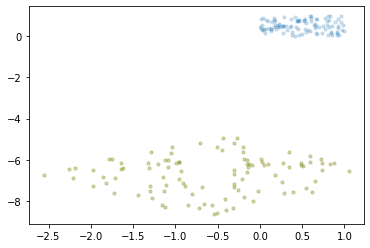

In [9]:
Z = opa(X, Y, coords=True, fit="best")
plt.scatter(*X.T, s = 10, alpha = 0.20)
plt.scatter(*Y.T, s = 10, alpha = 0.20)
plt.scatter(*Z.T, s = 10, alpha = 0.20)

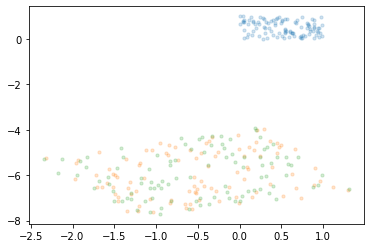

In [ ]:
Z = opa(X, Y, fit="rotation-only", coords=True)
plt.scatter(*X.T, s = 10, alpha = 0.20)
plt.scatter(*Y.T, s = 10, alpha = 0.20)
plt.scatter(*Z.T, s = 10, alpha = 0.20)

# Without Scaling

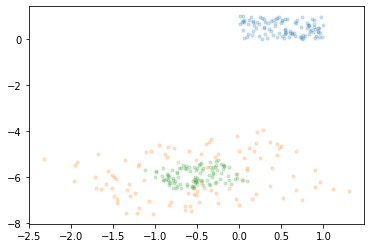

In [ ]:
Z = opa(X, Y, coords=True, scale=False)
plt.scatter(*X.T, s = 10, alpha = 0.20)
plt.scatter(*Y.T, s = 10, alpha = 0.20)
plt.scatter(*Z.T, s = 10, alpha = 0.20)

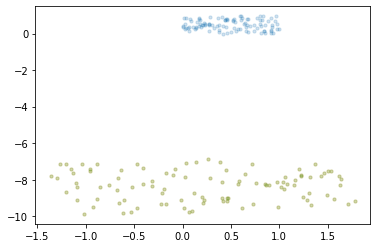

In [ ]:
from tallem.alignment import scale_points
R, s, t, d = opa(X, Y, scale=True).values()
Z = ((s*(X - X.mean(axis=0))) @ R) + X.mean(axis=0) + t
plt.scatter(*X.T, s = 10, alpha = 0.20)
plt.scatter(*Y.T, s = 10, alpha = 0.20)
plt.scatter(*Z.T, s = 10, alpha = 0.20)

3.0
R:  [[-0.9921147  -0.12533323]
 [ 0.12533323 -0.9921147 ]]
R2:  [[-0.9921147   0.12533323]
 [-0.12533323 -0.9921147 ]]
R det:  1.0000000000000002
R2 det:  1.0


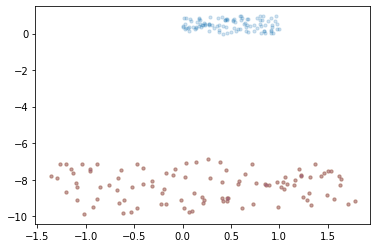

In [ ]:
## Testing hand-rolled solution w/ svd 
from numpy.linalg import svd
R, s, t, d = opa(X, Y, scale=True).values()
print(s)


# Scale and center X and Y
X_c = X - X.mean(axis=0)
X_sc = X_c / np.linalg.norm(X_c)

Y_c = Y - Y.mean(axis=0)
Y_sc = Y_c / np.linalg.norm(Y_c)

A = X_sc.T 
B = Y_sc.T 

U, svals, Vt = svd(B @ A.T)
R2 = U @ Vt
print("R: ", R)
print("R2: ", R2)
print("R det: ", np.linalg.det(R))
print("R2 det: ", np.linalg.det(R2))

# plt.scatter(*X_sc.T, s = 10, alpha = 0.20)
# plt.scatter(*Y_sc.T, s = 10, alpha = 0.20)
# plt.scatter(*((R2 @ X_sc.T).T).T, s = 10, alpha = 0.20)

#Z = ((s*(X - X.mean(axis=0))) @ R2) + X.mean(axis=0) + t
Z = (s*(R2 @ (X - X.mean(axis=0)).T)).T + X.mean(axis=0) + t
H = ((s*(X - X.mean(axis=0))) @ R) + X.mean(axis=0) + t
plt.scatter(*X.T, s = 10, alpha = 0.20)
plt.scatter(*Y.T, s = 10, alpha = 0.20)
plt.scatter(*Z.T, s = 10, alpha = 0.20)
plt.scatter(*H.T, s = 10, alpha = 0.20)

m = X.shape[1]
d = np.sign(np.linalg.det(U) * np.linalg.det(Vt))
S = np.diag([1] * (m - 1) + [d])
R3 = U @ S @ Vt

J = (s*(R3 @ (X - X.mean(axis=0)).T)).T + X.mean(axis=0) + t
plt.scatter(*J.T, s = 10, alpha = 0.20)

# 	c = VarA / np.trace(np.diag(D) @ S)
# 	t = EA - c * R @ EB



# sgn_fix = np.append(np.repeat(1.0, len(svals)-1.0), np.linalg.det(U)*np.linalg.det(Vt.T))
# print(sgn_fix)
# R3 = U @ np.diag(sgn_fix) @ Vt
# print("R3: ", R3)
# print("R3 det: ", np.linalg.det(R3))

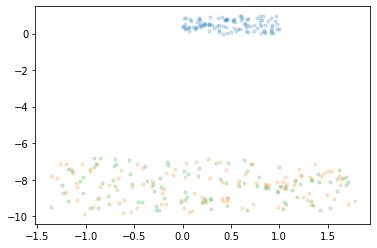

In [ ]:
Z = ((s*(X - X.mean(axis=0))) @ R3) + X.mean(axis=0) + t
plt.scatter(*X.T, s = 10, alpha = 0.20)
plt.scatter(*Y.T, s = 10, alpha = 0.20)
plt.scatter(*Z.T, s = 10, alpha = 0.20)

[1. 1.]


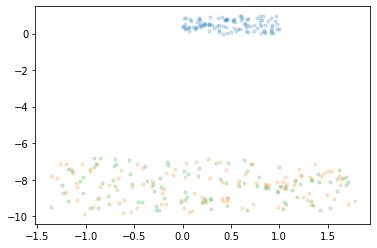

In [ ]:
## Kabsch algorithm 
X_c = X - X.mean(axis=0)
Y_c = Y - Y.mean(axis=0)
H = X_c.T @ Y_c
U, s, Vt = np.linalg.svd(H)
d = np.sign(np.linalg.det(Vt.T @ U.T))
I = np.repeat(1.0, Vt.shape[0])
I[-1] = d
print(I)
R3 = Vt.T @ np.diag(I) @ U 

sc = np.linalg.norm(Y_c, "fro")/np.linalg.norm(X_c, "fro")
Z = (X_c @ R3)*sc + X.mean(axis=0) + t
plt.scatter(*X.T, s = 10, alpha = 0.20)
plt.scatter(*Y.T, s = 10, alpha = 0.20)
plt.scatter(*Z.T, s = 10, alpha = 0.20)

R:  [[-0.9921147   0.12533323]
 [-0.12533323 -0.9921147 ]]


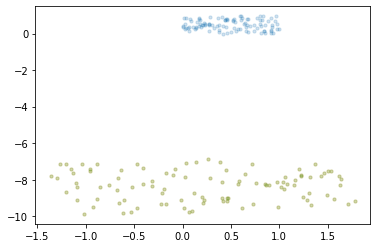

In [ ]:
def kabsch_umeyama(A, B):
	assert A.shape == B.shape
	n, m = A.shape

	EA = np.mean(A, axis=0)
	EB = np.mean(B, axis=0)
	VarA = np.mean(np.linalg.norm(A - EA, axis=1) ** 2)

	H = ((A - EA).T @ (B - EB)) / n
	U, D, VT = np.linalg.svd(H)
	d = np.sign(np.linalg.det(U) * np.linalg.det(VT))
	S = np.diag([1] * (m - 1) + [d])

	R = U @ S @ VT
	c = VarA / np.trace(np.diag(D) @ S)
	t = EA - c * R @ EB

	return R, c, t

R, c, t = kabsch_umeyama(Y, X)
# R, c, t = kabsch_umeyama(X_sc, Y_sc)
print("R: ", R)

# Z = (X_c*c) @ R + X.mean(axis=0) + t
Z = np.array([t + c * R @ x for x in X])

plt.scatter(*X.T, s = 10, alpha = 0.20)
plt.scatter(*Y.T, s = 10, alpha = 0.20)
plt.scatter(*Z.T, s = 10, alpha = 0.20)

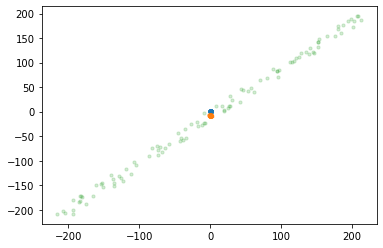

In [ ]:
# Z = ((s*(X - X.mean(axis=0))) @ R3) + X.mean(axis=0) + t
# https://en.wikipedia.org/wiki/Wahba%27s_problem
B = X.T @ Y
U, s, Vt = svd(B)
sgn_fix = np.append(np.repeat(1.0, len(s)-1.0), np.linalg.det(U)*np.linalg.det(Vt.T))
R3 = U @ np.diag(sgn_fix) @ Vt

# Vt[:,[-1]] = -Vt[:,[-1]]
# R3 = U @ Vt
Z = ((s*X_c) @ R3) + X.mean(axis=0) + t
plt.scatter(*X.T, s = 10, alpha = 0.20)
plt.scatter(*Y.T, s = 10, alpha = 0.20)
plt.scatter(*Z.T, s = 10, alpha = 0.20)